### Import packages

In [1]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import geopandas as gpd
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point
from shapely.ops import transform
from scipy.spatial import cKDTree
from itertools import cycle
import pyproj
from pathlib import Path
import osmnx as ox
import math
import matplotlib.pyplot as plt
import random
import geopandas as gpd
import folium
from pathlib import Path

### Load barrios y puntos CID

In [2]:
def cargar_geojson(nombre_archivo, directorio_base='../../../../data/delivetter'):
    """
    Carga un archivo GeoJSON específico y devuelve un GeoDataFrame.
    
    Args:
        nombre_archivo (str): Nombre del archivo GeoJSON (ej. 'barris.geojson').
        directorio_base (str): Ruta relativa al directorio donde se encuentra el archivo.
                              Por defecto: '../../data/delivetter'.
    
    Returns:
        gpd.GeoDataFrame: GeoDataFrame con los datos del archivo.
        None: Si el archivo no existe o hay un error.
    """
    try:
        ruta = Path(directorio_base) / nombre_archivo
        
        if not ruta.exists():
            raise FileNotFoundError(f"Archivo no encontrado: {ruta.absolute()}")
        
        gdf = gpd.read_file(ruta)
        print(f"✅ '{nombre_archivo}' cargado correctamente ({len(gdf)} registros)")
        return gdf
    
    except Exception as e:
        print(f"❌ Error al cargar '{nombre_archivo}': {str(e)}")
        return None
    
barrios = cargar_geojson('barris.geojson')
catastro = cargar_geojson('catastro.geojson')
puntos_carga = cargar_geojson('puntosCID.geojson')

✅ 'barris.geojson' cargado correctamente (88 registros)
✅ 'catastro.geojson' cargado correctamente (36346 registros)
✅ 'puntosCID.geojson' cargado correctamente (885 registros)


### Functions

In [3]:
def graph_map(G_vehicle, G_pedestrian, shp_zone, shp_loading_points, bajos):
    mapa = folium.Map(location=[shp_zone.centroid.y, shp_zone.centroid.x], zoom_start=16)

    gdf_edges_vehicle = ox.graph_to_gdfs(G_vehicle, nodes=False, edges=True)
    gdf_edges_pedestrian = ox.graph_to_gdfs(G_pedestrian, nodes=False, edges=True)

    bajos_in_zone = bajos[bajos.intersects(shp_zone)]

    # Agregar líneas con tooltip del tipo 'highway'
    for grafo, color in [(gdf_edges_vehicle, "blue"), (gdf_edges_pedestrian, "red")]:
        for _, row in grafo.iterrows():
            if row["geometry"].geom_type == "LineString":
                puntos = [(p[1], p[0]) for p in row["geometry"].coords]
                tipo_highway = row.get("highway", "Desconocido")
                
                if isinstance(tipo_highway, list):
                    tipo_highway = ", ".join(tipo_highway)  # Si es lista, unir
                    print('hola')

                folium.PolyLine(
                    puntos,
                    weight=2,
                    opacity=1,
                    color=color,
                    tooltip=f"highway: {tipo_highway}"
                ).add_to(mapa)

    # Zona del barrio
    folium.GeoJson(
        shp_zone,
        style_function=lambda feature: {
            "color": "green",
            "weight": 6,
            "fill": True,
            "fillColor": "limegreen",
            "fillOpacity": 0.2
        }
    ).add_to(mapa)

    # Puntos de carga
    shp_loading_points.apply(lambda row: folium.CircleMarker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        radius=8,
        color="black",
        fill=True,
        fill_color="orange",
        fill_opacity=1,
        popup=row.get("NOMBRE", "Punto de carga")
    ).add_to(mapa), axis=1)

    # Marcadores para bajos
    for _, row in bajos_in_zone.sample(n=len(bajos_in_zone), random_state=None).iterrows():
        if not row['Almacen'] and not row['Comercio']:
            continue

        centroide = row.geometry.centroid

        if row['Almacen'] and row['Comercio']:
            fill_color = 'black'
            tipo = "Almacén y Comercio"
        elif row['Almacen']:
            fill_color = 'purple'
            tipo = "Almacén"
        elif row['Comercio']:
            fill_color = 'lightblue'
            tipo = "Comercio"

        folium.CircleMarker(
            location=[centroide.y, centroide.x],
            radius=8,
            color='black',
            fill=True,
            fill_color=fill_color,
            fill_opacity=1,
            popup=tipo
        ).add_to(mapa)

    # Leyenda
    legend_html = '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 250px; height: 130px; 
                            background-color: white; z-index:9999; font-size:13px;
                            border:1px solid grey; border-radius: 5px; padding: 8px;
                            box-shadow: 2px 2px 5px rgba(0,0,0,0.2);">
                    <b style="font-size:14px;">Leyenda</b> <br>
                    <i class="fa fa-circle" style="color:black; margin-right:5px;"></i> Almacén y Comercio <br>
                    <i class="fa fa-circle" style="color:orange; margin-right:5px;"></i> Punto CID (origen M1) <br>
                    <i class="fa fa-circle" style="color:purple; margin-right:5px;"></i> Almacén (origen M3) <br>
                    <i class="fa fa-circle" style="color:lightblue; margin-right:5px;"></i> Comercio (entrega) <br>
                    <i class="fa fa-square" style="color:limegreen; margin-right:5px;"></i> Barrio
                </div>
                '''
    mapa.get_root().html.add_child(folium.Element(legend_html))

    return mapa


In [4]:
def get_graph(request):
    shp_neighbourhood = barrios[barrios["nombre"].str.upper().str.contains(request.strip().upper())]
    while len(shp_neighbourhood) != 1:
        request = input("Please, introduce a valid neighbourhood: ")
        shp_neighbourhood = barrios[barrios["nombre"].str.upper().str.contains(request.strip().upper())]
    shp_zone = shp_neighbourhood["geometry"].values[0]
    shp_loading_points = puntos_carga[puntos_carga.intersects(shp_zone)]
    shp_bajos = catastro[catastro.intersects(shp_zone)]

    G = ox.graph_from_polygon(shp_zone, 
                              network_type="all_public",  
                              simplify=False, 
                              retain_all=False,  
                              truncate_by_edge=True) 
    not_highway = ['elevator', 'busway', 'corridor', 'unclassified', 'services', 'cycleway', 'steps', 'service']

    allowed_vehicle = ['motorway', 'residential', 'secondary', 'living_street',
                    'primary_link', 'primary', 'tertiary', 'trunk', 'service',
                    'tertiary_link', 'trunk_link', 'secondary_link', 'motorway_link', 'road']
    
    allowed_pedestrian = ["pedestrian", "footway", "path", "track", "bridleway"]
    edges_to_remove = [(u, v, k) for u, v, k, data in G.edges(keys=True, data=True) 
                   if data.get('highway') in not_highway or data.get('access') in ['private', 'no', 'customers']]
    G.remove_edges_from(edges_to_remove)

    G_vehicle = G.copy()  
    edges_to_remove_vehicle = [(u, v, k) for u, v, k, data in G_vehicle.edges(keys=True, data=True) 
                                   if data.get('highway') not in allowed_vehicle]
    G_vehicle.remove_edges_from(edges_to_remove_vehicle)
    
    G_pedestrian = G.copy()  
    edges_to_remove_pedestrian = [(u, v, k) for u, v, k, data in G_pedestrian.edges(keys=True, data=True) 
                                      if data.get('highway') not in allowed_pedestrian]
    G_pedestrian.remove_edges_from(edges_to_remove_pedestrian)

    for graph in [G_vehicle, G_pedestrian]:
        nodes_to_remove = [node for node in graph.nodes if graph.degree(node) == 0]
        graph.remove_nodes_from(nodes_to_remove)

    for u, v, k, data in G_pedestrian.edges(keys=True, data=True):
        data['oneway'] = False


    print(f"Grafo para vehículos: {len(G_vehicle.nodes)} nodos, {len(G_vehicle.edges)} aristas")
    print(f"Grafo para peatones: {len(G_pedestrian.nodes)} nodos, {len(G_pedestrian.edges)} aristas")
    

    fig, ax = plt.subplots(2,1, figsize=(20, 15))
    
    ax[0].set_title("Grafo para vehículos")
    ox.plot_graph(G_vehicle, ax=ax[0], node_size=3, node_color='green', 
                  edge_linewidth=0.5, edge_color='blue', bgcolor="white", show=False)

    ax[1].set_title("Grafo para peatones")
    ox.plot_graph(G_pedestrian, ax=ax[1], node_size=3, node_color='green', 
                  edge_linewidth=0.5, edge_color='red', bgcolor="white", show=False)
    
    plt.show()
    
    return G_vehicle, G_pedestrian, shp_zone, shp_loading_points, shp_bajos
    



def graph_map(G_vehicle, G_pedestrian, shp_zone, shp_loading_points, bajos):
    mapa = folium.Map(location=[shp_zone.centroid.y, shp_zone.centroid.x], zoom_start=16)

    gdf_edges_vehicle = ox.graph_to_gdfs(G_vehicle, nodes=False, edges=True)
    gdf_edges_pedestrian = ox.graph_to_gdfs(G_pedestrian, nodes=False, edges=True)
    
    bajos_in_zone = bajos[bajos.intersects(shp_zone)]
    
    for grafo, color in [(gdf_edges_vehicle, "blue"), (gdf_edges_pedestrian, "red")]:
        for _, row in grafo.iterrows():
            if row["geometry"].geom_type == "LineString":
                puntos = [(p[1], p[0]) for p in row["geometry"].coords]
                folium.PolyLine(puntos, weight=2, opacity=1, color=color).add_to(mapa)

    folium.GeoJson(
        shp_zone,  
        style_function=lambda feature: {
            "color": "green", 
            "weight": 6,  
            "fill": True,  
            "fillColor": "limegreen",  
            "fillOpacity": 0.2  
        }
    ).add_to(mapa)

    shp_loading_points.apply(lambda row: folium.CircleMarker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x], 
        radius=8,  
        color="black",  
        fill=True,
        fill_color="orange",  
        fill_opacity=1, 
        popup=row.get("NOMBRE", "Punto de carga")
    ).add_to(mapa), axis=1)

    COLOR_CARGA = 'blue'  # Cambiado de orange a blue
    COLOR_ENTREGA = 'red'  # Cambiado de purple a red

    # Iterar sobre los bajos seleccionados
    for _, row in bajos_in_zone.sample(n=len(bajos_in_zone) // 1, random_state=None).iterrows():
    # Saltar puntos sin tipo
        if not row['Almacen'] and not row['Comercio']:
            continue
            
        centroide = row.geometry.centroid
        
        # Determinar color según las condiciones
        if row['Almacen'] and row['Comercio']:
            fill_color = 'black'
            tipo = "Almacén y Comercio"
        elif row['Almacen']:
            fill_color = 'purple'
            tipo = "Almacén"
        elif row['Comercio']:
            fill_color = 'lightblue'
            tipo = "Comercio"
        
        # Crear el marcador con borde negro
        folium.CircleMarker(
            location=[centroide.y, centroide.x],
            radius=8,
            color='black',  # Borde siempre negro
            fill=True,
            fill_color=fill_color,
            fill_opacity=1,
            popup=tipo
        ).add_to(mapa)

        # Leyenda actualizada
    legend_html = '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 250px; height: 130px; 
                            background-color: white; z-index:9999; font-size:13px;
                            border:1px solid grey; border-radius: 5px; padding: 8px;
                            box-shadow: 2px 2px 5px rgba(0,0,0,0.2);">
                    <b style="font-size:14px;">Leyenda</b> <br>
                    <i class="fa fa-circle" style="color:black; margin-right:5px;"></i> Almacén y Comercio <br>
                    <i class="fa fa-circle" style="color:orange; margin-right:5px;"></i> Punto CID (origen M1) <br>
                    <i class="fa fa-circle" style="color:purple; margin-right:5px;"></i> Almacén (origen M3) <br>
                    <i class="fa fa-circle" style="color:lightblue; margin-right:5px;"></i> Comercio (entrega) <br>
                    <i class="fa fa-square" style="color:limegreen; margin-right:5px;"></i> Barrio
                </div>
                '''
    mapa.get_root().html.add_child(folium.Element(legend_html))
    
    return mapa

### Get the graph

| FAVARA               | BENICALAP             | SANT PAU                 | BORBOTO                  | BENIFARAIG               |
|----------------------|----------------------|--------------------------|--------------------------|--------------------------|
| CAMI REAL           | JAUME ROIG            | LA SEU                   | AIORA                    | TORMOS                   |
| LA FONTETA S.LLUIS  | LA PETXINA            | L'HORT DE SENABRE        | CIUTAT JARDI             | CAMI DE VERA             |
| LA PUNTA            | SANT MARCEL.LI        | FAITANAR                 | PINEDO                   | CASTELLAR-L'OLIVERAL     |
| BENIMAMET           | EL FORN D'ALCEDO      | MONTOLIVET               | CIUTAT DE LES ARTS I DE LES CIENCIES | NA ROVELLA             |
| SANT LLORENS        | NATZARET              | LA CREU COBERTA          | L'AMISTAT                | EL GRAU                  |
| CIUTAT FALLERA      | RAFALELL-VISTABELLA   | LA CARRASCA              | BENIFERRI                | EL SALER                 |
| NOU MOLES           | MORVEDRE              | TRINITAT                 | CAMPANAR                 | EL CARME                 |
| LA LLUM             | LA VEGA BAIXA         | LA XEREA                 | L'ILLA PERDUDA           | TRES FORQUES             |
| LA MALVA-ROSA       | EL MERCAT             | LA ROQUETA               | LA GRAN VIA              | CAMI FONDO               |
| EL CALVARI          | LA RAIOSA             | SAFRANAR                 | SANT ISIDRE              | MALILLA                  |
| LES TENDETES        | PATRAIX               | RUSSAFA                  | LA CREU DEL GRAU         | LES CASES DE BARCENA     |
| CIUTAT UNIVERSITARIA | MAHUELLA-TAULADELLA  | MASSARROJOS              | CARPESA                  | TORREFIEL                |
| EL BOTANIC          | SANT ANTONI           | BENIMACLET               | MARXALENES               | EXPOSICIO                |
| BETERO              | CABANYAL-CANYAMELAR   | MESTALLA                 | EL PILAR                 | EL PLA DEL REMEI         |
| ALBORS              | ARRANCAPINS           | EN CORTS                 | POBLE NOU                | LA TORRE                 |
| SANT FRANCESC       | PENYA-ROJA            | ELS ORRIOLS              | VARA DE QUART            | SOTERNES                 |
| LA FONTSANTA        | EL PERELLONET         | EL PALMAR                | LA XEREA                 | L'ILLA PERDUDA           |


Grafo para vehículos: 440 nodos, 476 aristas
Grafo para peatones: 1097 nodos, 2471 aristas


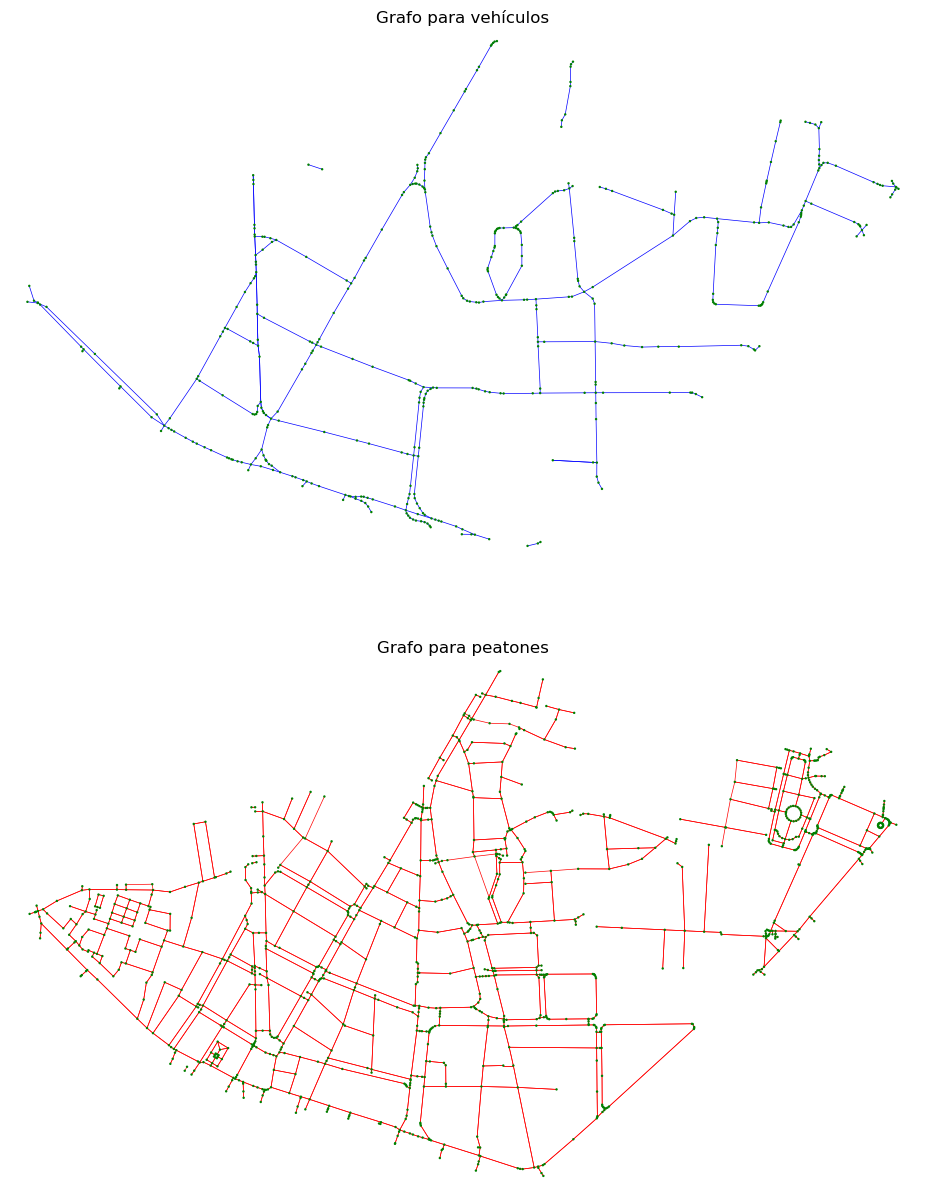

In [5]:
G_drive, G_walk, shp_zone, shp_loading_points, shp_bajos= get_graph('Sant France')
graph_map(G_drive, G_walk, shp_zone, shp_loading_points, shp_bajos)

In [6]:
import networkx as nx
from shapely.geometry import Point
import numpy as np
from scipy.spatial import cKDTree
import osmnx as ox
from shapely.ops import transform
import pyproj

# ==============================
# 1. Crear el supergrafo
# ==============================

# Etiquetar aristas
for u, v, k, data in G_drive.edges(keys=True, data=True):
    data['mode'] = 'drive'

for u, v, k, data in G_walk.edges(keys=True, data=True):
    data['mode'] = 'walk'

# Unir los dos grafos
G_super = nx.compose(G_drive, G_walk)

# ==============================
# 2. Preparar k-d trees para búsquedas rápidas
# ==============================

# Proyectar grafos
G_drive_proj = ox.project_graph(G_drive)
G_walk_proj = ox.project_graph(G_walk)

# Extraer nodos y coordenadas proyectadas
nodes_drive = ox.graph_to_gdfs(G_drive_proj, edges=False)
nodes_walk = ox.graph_to_gdfs(G_walk_proj, edges=False)

coords_drive = np.vstack((nodes_drive['x'], nodes_drive['y'])).T
coords_walk = np.vstack((nodes_walk['x'], nodes_walk['y'])).T

kdtree_drive = cKDTree(coords_drive)
kdtree_walk = cKDTree(coords_walk)

index_to_node_drive = np.array(nodes_drive.index)
index_to_node_walk = np.array(nodes_walk.index)

# Transformador de coordenadas: WGS84 -> CRS proyectado
project_geom = pyproj.Transformer.from_crs("EPSG:4326", nodes_drive.crs, always_xy=True).transform

# ==============================
# 3. Añadir nodos especiales (usando k-d tree)
# ==============================

def add_special_node(G, geom, tipo, id_):
    """Añade un nodo especial (punto carga, comercio, almacén) y lo conecta"""
    nodo_id = f"{tipo}_{id_}"
    G.add_node(nodo_id, x=geom.centroid.x, y=geom.centroid.y, tipo=tipo)

    # Proyectar punto al sistema del grafo correspondiente
    geom_proj = transform(project_geom, geom.centroid)
    x, y = geom_proj.x, geom_proj.y

    # Buscar nodo más cercano
    if tipo == "carga":
        dist, idx = kdtree_drive.query([x, y])
        nearest = index_to_node_drive[idx]
    else:
        dist, idx = kdtree_walk.query([x, y])
        nearest = index_to_node_walk[idx]

    # Añadir aristas bidireccionales
    G.add_edge(nodo_id, nearest, mode='connection', length=dist)
    G.add_edge(nearest, nodo_id, mode='connection', length=dist)

    return nodo_id

# ==============================
# 4. Añadir todos los nodos especiales
# ==============================

nodos_carga = []
for i, row in shp_loading_points.iterrows():
    nodo = add_special_node(G_super, row.geometry, "carga", i)
    nodos_carga.append(nodo)

nodos_comercios = []
for i, row in shp_bajos[shp_bajos['Comercio'] == True].iterrows():
    nodo = add_special_node(G_super, row.geometry, "comercio", i)
    nodos_comercios.append(nodo)

nodos_almacenes = []
for i, row in shp_bajos[shp_bajos['Almacen'] == True].iterrows():
    nodo = add_special_node(G_super, row.geometry, "almacen", i)
    nodos_almacenes.append(nodo)

print(f"✅ Supergrafo creado con {len(G_super.nodes)} nodos y {len(G_super.edges)} aristas.")


✅ Supergrafo creado con 1743 nodos y 3667 aristas.


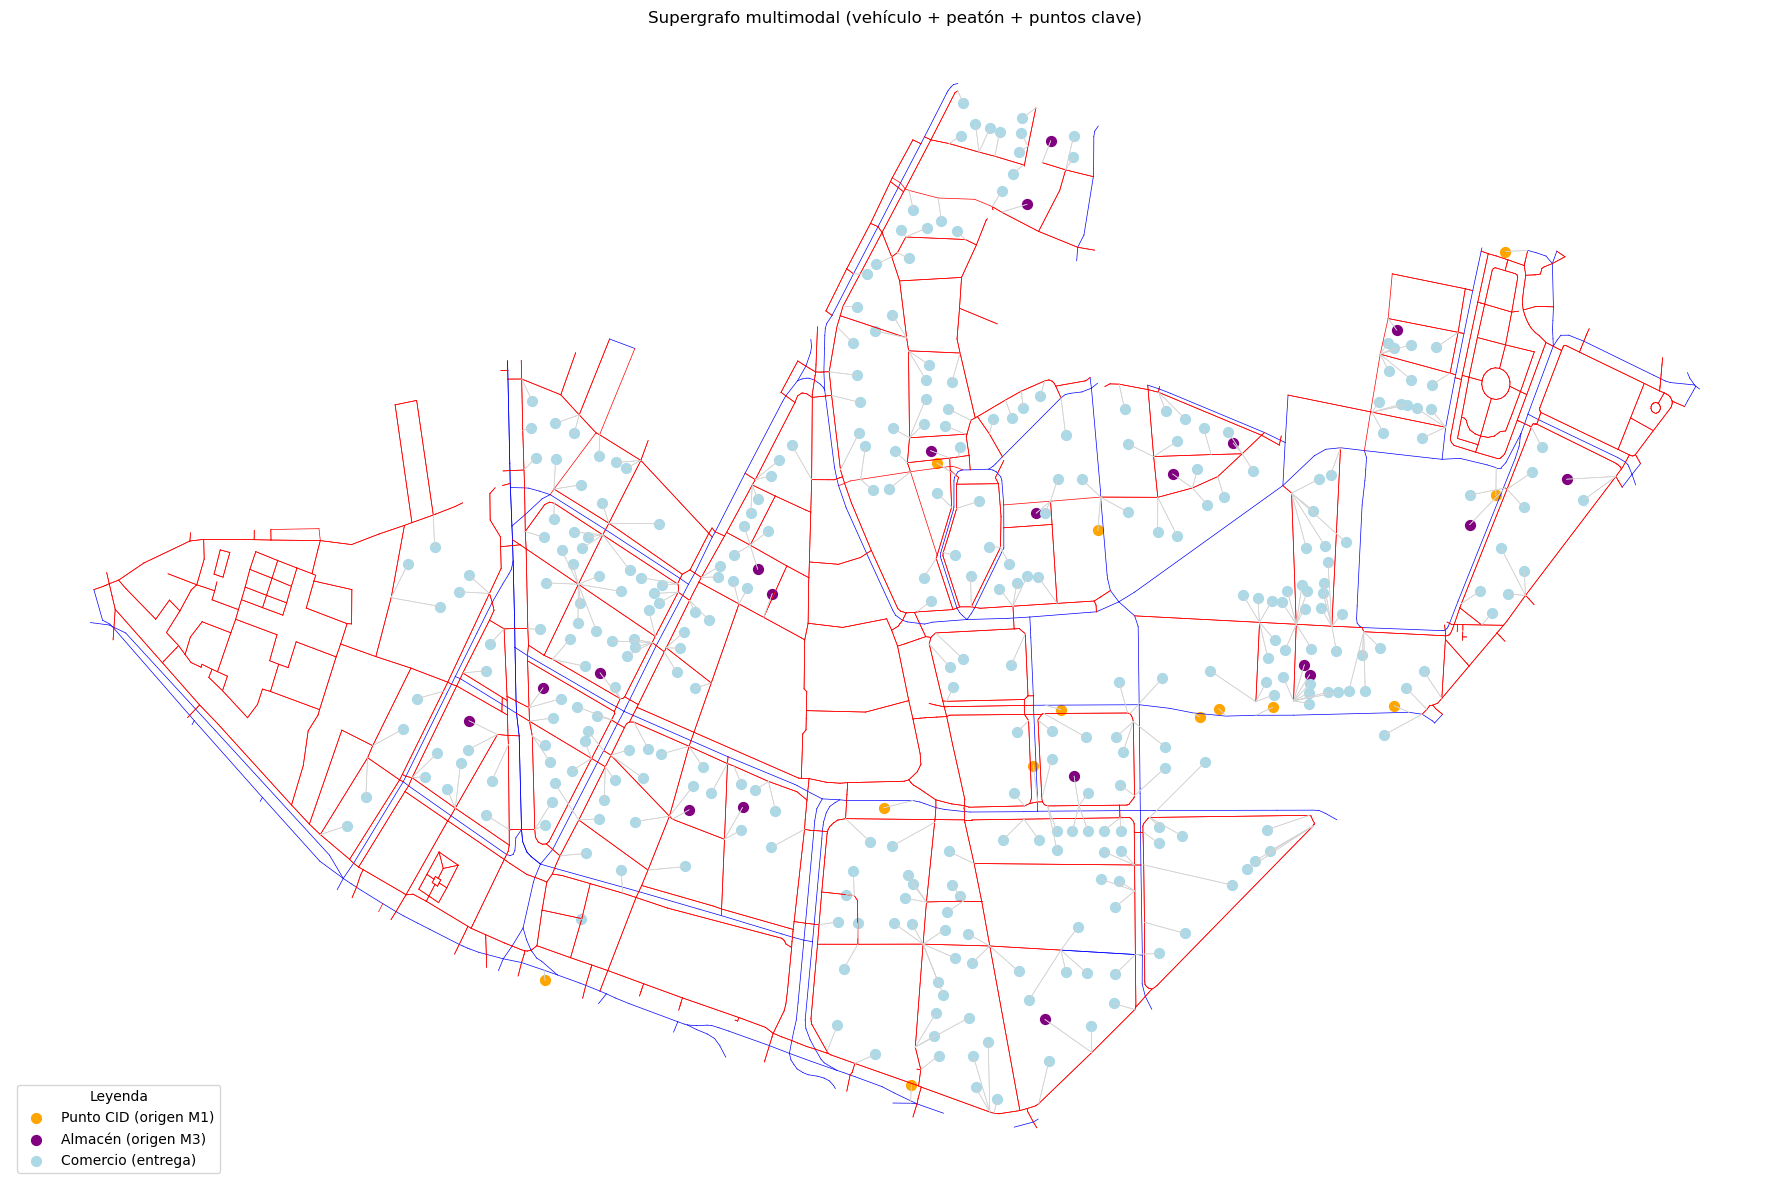

In [7]:
import matplotlib.pyplot as plt

# ==========================
# Visualización del supergrafo con leyenda personalizada
# ==========================

fig, ax = plt.subplots(figsize=(18, 12))

# ==========================
# 1. Pintar aristas por tipo
# ==========================
edge_colors = {'drive': 'blue', 'walk': 'red', 'connection': 'lightgray'}
edges_by_mode = {'drive': [], 'walk': [], 'connection': []}

for u, v, data in G_super.edges(data=True):
    mode = data.get('mode', 'connection')
    x0, y0 = G_super.nodes[u]['x'], G_super.nodes[u]['y']
    x1, y1 = G_super.nodes[v]['x'], G_super.nodes[v]['y']
    edges_by_mode[mode].append(([x0, x1], [y0, y1]))

for mode, lines in edges_by_mode.items():
    for x_vals, y_vals in lines:
        ax.plot(x_vals, y_vals, color=edge_colors[mode], linewidth=0.5)

# ==========================
# 2. Pintar nodos según leyenda
# ==========================

# Inicializar categorías
categorias = {
    'cid': {'coords': [], 'color': 'orange', 'label': 'Punto CID (origen M1)'},
    'almacen_m3': {'coords': [], 'color': 'purple', 'label': 'Almacén (origen M3)'},
    'comercio_entrega': {'coords': [], 'color': 'lightblue', 'label': 'Comercio (entrega)'},
    'almacen_y_comercio': {'coords': [], 'color': 'black', 'label': 'Almacén y Comercio'},
}

# Clasificación según tipo o combinación de tipos
for nodo, data in G_super.nodes(data=True):
    if isinstance(nodo, str):
        tipo = data.get('tipo')
        if tipo == 'carga':
            categorias['cid']['coords'].append((data['x'], data['y']))
        elif tipo == 'almacen' and 'comercio' in nodo:
            categorias['almacen_y_comercio']['coords'].append((data['x'], data['y']))
        elif tipo == 'almacen':
            categorias['almacen_m3']['coords'].append((data['x'], data['y']))
        elif tipo == 'comercio':
            categorias['comercio_entrega']['coords'].append((data['x'], data['y']))

# Pintar nodos por categoría
for cat in categorias.values():
    if cat['coords']:
        xs, ys = zip(*cat['coords'])
        ax.scatter(xs, ys, color=cat['color'], s=50, label=cat['label'])

# ==========================
# 3. Estilo y leyenda
# ==========================
ax.set_title("Supergrafo multimodal (vehículo + peatón + puntos clave)")
ax.axis('off')

# Leyenda limpia sin duplicados
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower left', title='Leyenda')

plt.tight_layout()
plt.show()



⏱️ Tiempo total estimado: 61.0 min
🚐 Tiempo total conduciendo: 2.0 min
🚶‍♂️ Tiempo total andando: 58.9 min

📦 Resumen detallado por punto de carga:

🟠 Punto de carga: carga_175 (tiempo de llegada: 49.1 min)
  - 📍 Comercio comercio_18723 | Paquetes: 4 | Tiempo caminata: 170.4 min
  - 📍 Comercio comercio_16400 | Paquetes: 4 | Tiempo caminata: 151.2 min
  - 📍 Comercio comercio_15851 | Paquetes: 4 | Tiempo caminata: 169.4 min
  - 📍 Comercio comercio_19658 | Paquetes: 2 | Tiempo caminata: 40.8 min
  - 📍 Comercio comercio_18729 | Paquetes: 3 | Tiempo caminata: 234.4 min
  - 📍 Comercio comercio_19650 | Paquetes: 5 | Tiempo caminata: 109.2 min

🟠 Punto de carga: carga_733 (tiempo de llegada: 2.0 min)
  - 📍 Comercio comercio_21106 | Paquetes: 2 | Tiempo caminata: 108.3 min
  - 📍 Comercio comercio_21107 | Paquetes: 1 | Tiempo caminata: 18.4 min

🟠 Punto de carga: carga_764 (tiempo de llegada: 0.0 min)
  - 📍 Comercio comercio_19669 | Paquetes: 5 | Tiempo caminata: 73.6 min
  - 📍 Comercio comerci

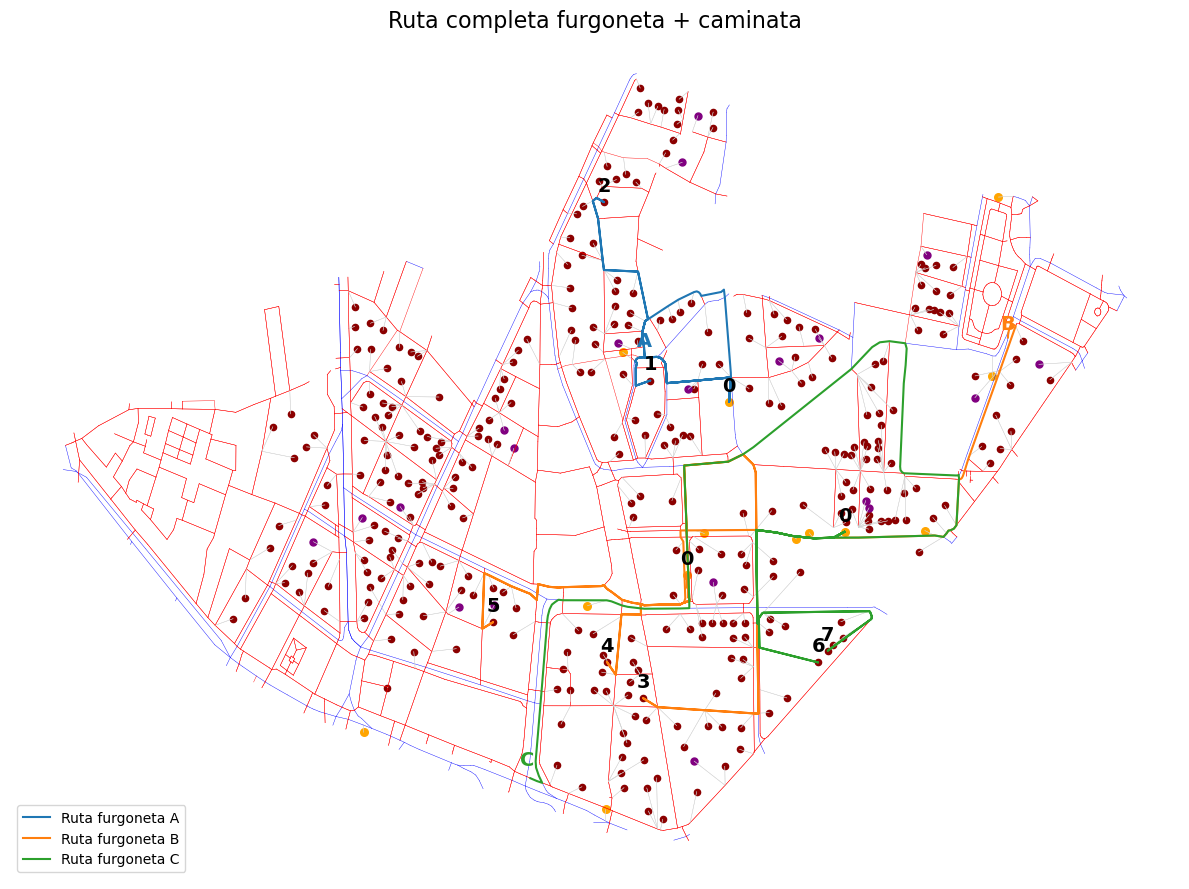

In [8]:
import networkx as nx
import numpy as np
import random
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.spatial import cKDTree

# ==============================
# CONFIGURACIÓN
# ==============================

N_CID = 3
N_COMERCIOS = 10
PAQUETES_MIN = 1
PAQUETES_MAX = 5
CAPACIDAD_MAXIMA = 10  # Paquetes que puede llevar en la mano el repartidor
VELOCIDAD_VEHICULO = 20  # km/h
VELOCIDAD_PEATON = 5     # km/h

# ==============================
# 1. Seleccionar comercios y asignar paquetes
# ==============================

bajos_sample = random.sample(nodos_comercios, k=min(N_COMERCIOS, len(nodos_comercios)))
df = pd.DataFrame([{'nodo': n, **G_super.nodes[n]} for n in bajos_sample])
bajos_sample = gpd.GeoDataFrame(df, geometry=[Point(row['x'], row['y']) for _, row in df.iterrows()], crs="EPSG:4326")
bajos_sample['paquetes'] = np.random.randint(PAQUETES_MIN, PAQUETES_MAX + 1, size=len(bajos_sample))

loading_sample = random.sample(nodos_carga, k=min(N_CID, len(nodos_carga)))
df = pd.DataFrame([{'nodo': n, **G_super.nodes[n]} for n in loading_sample])
loading_sample = gpd.GeoDataFrame(df, geometry=[Point(row['x'], row['y']) for _, row in df.iterrows()], crs="EPSG:4326")

# ==============================
# 2. Asignar punto de carga más cercano
# ==============================

carga_coords = np.array([(geom.centroid.y, geom.centroid.x) for geom in loading_sample.geometry])
tree = cKDTree(carga_coords)
entrega_coords = np.array([(geom.centroid.y, geom.centroid.x) for geom in bajos_sample.geometry])
distancias, indices = tree.query(entrega_coords, k=1)

bajos_sample['carga_geom'] = [loading_sample.iloc[i].geometry for i in indices]
bajos_sample['carga_nodo'] = [loading_sample.iloc[i]['nodo'] for i in indices]
bajos_sample['distancia_carga_m'] = distancias * 111000  # corregido



# ==============================
# 3. FUNCIONES AUXILIARES
# ==============================

def calcular_tiempos_en_aristas(G):
    for u, v, k, data in G.edges(keys=True, data=True):
        distancia = data.get('length', 0)
        modo = data.get('mode', 'drive')

        if modo in ['walk', 'connection']:
            velocidad_kmh = 5
        elif modo == 'drive':
            maxspeed = data.get('maxspeed', 35)
            if isinstance(maxspeed, str):
                try:
                    velocidad_kmh = int(''.join(filter(str.isdigit, maxspeed)))
                except ValueError:
                    velocidad_kmh = 35
            else:
                velocidad_kmh = maxspeed
        else:
            velocidad_kmh = 35

        velocidad_ms = velocidad_kmh * 1000 / 3600
        tiempo_segundos = distancia / velocidad_ms if velocidad_ms > 0 else float('inf')
        data['tiempo_segundos'] = tiempo_segundos

def calcular_tiempo_drive(origen, destino):
    try:
        camino = nx.shortest_path(G_super, origen, destino, weight='tiempo_segundos')
    except nx.NetworkXNoPath:
        return float('inf'), None

    tiempo = 0
    for i in range(len(camino) - 1):
        u, v = camino[i], camino[i + 1]
        data = list(G_super.get_edge_data(u, v).values())[0]
        modo = data.get('mode')

        if modo == 'drive':
            tiempo += data['tiempo_segundos']
        elif modo == 'connection' and i == 0:  # solo permitimos 1 salto inicial de conexión
            tiempo += data['tiempo_segundos']
        else:
            break  # no seguimos si entramos a otro tipo
    return tiempo, camino


def calcular_tiempo_walk(origen, destino):
    try:
        camino = nx.shortest_path(G_super, origen, destino, weight='tiempo_segundos')
    except nx.NetworkXNoPath:
        return float('inf'), None

    tiempo = sum(
        list(G_super.get_edge_data(camino[i], camino[i+1]).values())[0]['tiempo_segundos']
        for i in range(len(camino)-1)
        if list(G_super.get_edge_data(camino[i], camino[i+1]).values())[0].get('mode') == 'walk'
    )
    return tiempo, camino

# ==============================
# 4. Calcular rutas y tiempos (multi-furgoneta por CID, robusto)
# ==============================

calcular_tiempos_en_aristas(G_super)

ruta_total = []
tiempo_drive = 0
tiempo_walk = 0
comercios_visitados = set()
inicios_furgoneta = []
rutas_por_furgoneta = []

# Agrupar por carga
agrupados_por_cid = bajos_sample.groupby('carga_nodo')
nodos_validos = [cid for cid in bajos_sample['carga_nodo'].unique() if cid in G_super.nodes]
cid_pendientes = set(nodos_validos)

while cid_pendientes:
    # ==============================
    # Elegir nuevo punto de inicio válido aleatorio
    # ==============================
    boundary_nodes = [
        node for node, data in G_drive.nodes(data=True)
        if shp_zone.boundary.distance(Point(data['x'], data['y'])) < 0.001
    ]
    random.shuffle(boundary_nodes)

    punto_inicio = None
    nodo_carga = None
    camino_drive = None
    for origen in boundary_nodes:
        cid_ordenados = sorted(cid_pendientes, key=lambda cid: calcular_tiempo_drive(origen, cid)[0])
        for cid in cid_ordenados:
            t_drive, camino = calcular_tiempo_drive(origen, cid)
            if camino is not None and np.isfinite(t_drive):
                punto_inicio = origen
                nodo_carga = cid
                camino_drive = camino
                tiempo_drive_actual = t_drive
                break
        if punto_inicio is not None:
            break

    if punto_inicio is None:
        raise ValueError("❌ No se encontró ningún punto de inicio válido para los CiD restantes.")

    inicios_furgoneta.append(punto_inicio)
    rutas_furgoneta_actual = camino_drive[1:] if camino_drive else []
    tiempo_drive += tiempo_drive_actual
    ruta_total += rutas_furgoneta_actual

    sub_bajos = agrupados_por_cid.get_group(nodo_carga)
    pendientes = sub_bajos[~sub_bajos['nodo'].isin(comercios_visitados)].copy()

    carga_actual = 0
    nodo_actual = nodo_carga

    while not pendientes.empty:
        candidatos = []
        for _, row in pendientes.iterrows():
            nodo_comercio = row['nodo']
            paquetes = row['paquetes']

            if carga_actual + paquetes > CAPACIDAD_MAXIMA:
                continue

            try:
                tiempo, _ = calcular_tiempo_walk(nodo_actual, nodo_comercio)
                if np.isfinite(tiempo):
                    candidatos.append((nodo_comercio, tiempo, paquetes))
            except:
                continue

        if not candidatos:
            break

        nodo_siguiente, _, paquetes_siguiente = min(candidatos, key=lambda x: x[1])

        try:
            tiempo_ida, camino_ida = calcular_tiempo_walk(nodo_actual, nodo_siguiente)
            if not np.isfinite(tiempo_ida):
                raise ValueError
        except:
            pendientes = pendientes[pendientes['nodo'] != nodo_siguiente]
            continue

        distancia_ida = sum(
            G_super.edges[camino_ida[i], camino_ida[i + 1], 0]['length']
            for i in range(len(camino_ida) - 1)
        )
        tiempo_walk += distancia_ida / (VELOCIDAD_PEATON * 1000 / 60)
        ruta_total += camino_ida[1:]
        rutas_furgoneta_actual += camino_ida[1:]

        camino_vuelta = list(reversed(camino_ida))
        tiempo_walk += distancia_ida / (VELOCIDAD_PEATON * 1000 / 60)
        ruta_total += camino_vuelta[1:]
        rutas_furgoneta_actual += camino_vuelta[1:]

        carga_actual += paquetes_siguiente
        pendientes = pendientes[pendientes['nodo'] != nodo_siguiente]
        comercios_visitados.add(nodo_siguiente)
        nodo_actual = nodo_carga

    rutas_por_furgoneta.append(rutas_furgoneta_actual)
    cid_pendientes.remove(nodo_carga)

# ==============================
# 5. Resultados
# ==============================

tiempo_total = tiempo_drive + tiempo_walk

print(f"\n⏱️ Tiempo total estimado: {tiempo_total:.1f} min")
print(f"🚐 Tiempo total conduciendo: {tiempo_drive:.1f} min")
print(f"🚶‍♂️ Tiempo total andando: {tiempo_walk:.1f} min")

print("\n📦 Resumen detallado por punto de carga:")
for i, (cid, grupo) in enumerate(bajos_sample.groupby('carga_nodo')):
    try:
        inicio = inicios_furgoneta[i] if i < len(inicios_furgoneta) else None
        if inicio is not None:
            tiempo_llegada, _ = calcular_tiempo_drive(inicio, cid)
            if not np.isfinite(tiempo_llegada):
                raise ValueError
        else:
            raise ValueError
    except:
        tiempo_llegada = None
    llegada_str = f"{tiempo_llegada:.1f} min" if tiempo_llegada is not None else "no accesible"
    print(f"\n🟠 Punto de carga: {cid} (tiempo de llegada: {llegada_str})")
    for _, row in grupo.iterrows():
        nodo = row['nodo']
        paquetes = row['paquetes']
        try:
            tiempo_entrega, _ = calcular_tiempo_walk(cid, nodo)
            if not np.isfinite(tiempo_entrega):
                raise ValueError
        except:
            tiempo_entrega = None
        entrega_str = f"{tiempo_entrega:.1f} min" if tiempo_entrega is not None else "no accesible"
        print(f"  - 📍 Comercio {nodo} | Paquetes: {paquetes} | Tiempo caminata: {entrega_str}")

# ==============================
# 6. Visualización de la ruta
# ==============================

fig, ax = plt.subplots(figsize=(12, 9))

for u, v, data in G_super.edges(data=True):
    x0, y0 = G_super.nodes[u]['x'], G_super.nodes[u]['y']
    x1, y1 = G_super.nodes[v]['x'], G_super.nodes[v]['y']
    color = 'gray'
    if data['mode'] == 'drive':
        color = 'blue'
    elif data['mode'] == 'walk':
        color = 'red'
    elif data['mode'] == 'connection':
        color = 'lightgray'
    ax.plot([x0, x1], [y0, y1], color=color, linewidth=0.3)

for nodo, data in G_super.nodes(data=True):
    if data.get('tipo') == 'carga':
        ax.scatter(data['x'], data['y'], color='orange', s=30)
    elif data.get('tipo') == 'comercio':
        ax.scatter(data['x'], data['y'], color='darkred', s=20)
    elif data.get('tipo') == 'almacen':
        ax.scatter(data['x'], data['y'], color='purple', s=25)

from itertools import cycle
import matplotlib.colors as mcolors

colores = list(mcolors.TABLEAU_COLORS.values())
colores_cycle = cycle(colores)
furgoneta_labels = cycle("ABCDEFGHIJKLMNOPQRSTUVWXYZ")

nodos_vistos = set()
contador_comercio = 1
colores_furgonetas = {}
leyenda_usada = set()

for i, (inicio, letra) in enumerate(zip(inicios_furgoneta, furgoneta_labels)):
    color_actual = colores[i % len(colores)]
    colores_furgonetas[inicio] = color_actual
    rutas_furgoneta = rutas_por_furgoneta[i]
    coords_furgoneta = [(G_super.nodes[n]['x'], G_super.nodes[n]['y']) for n in rutas_furgoneta if n in G_super.nodes]
    if coords_furgoneta:
        xs, ys = zip(*coords_furgoneta)
        label = f"Ruta furgoneta {letra}"
        if label not in leyenda_usada:
            ax.plot(xs, ys, color=color_actual, linewidth=1.5, label=label)
            leyenda_usada.add(label)
        else:
            ax.plot(xs, ys, color=color_actual, linewidth=1.5)

    if inicio in G_super.nodes:
        x, y = G_super.nodes[inicio]['x'], G_super.nodes[inicio]['y']
        ax.annotate(letra, (x, y), textcoords="offset points", xytext=(0, 8),
                    ha='center', fontsize=14, fontweight='bold', color=color_actual)
        nodos_vistos.add(inicio)

nodo_carga_por_comercio = bajos_sample.set_index('nodo')['carga_nodo'].to_dict()

for nodo in ruta_total:
    if nodo in nodos_vistos or nodo not in G_super.nodes:
        continue

    tipo = G_super.nodes[nodo].get('tipo')
    if tipo == 'carga':
        texto = '0'
        color = 'black'
    elif tipo == 'comercio':
        texto = str(contador_comercio)
        contador_comercio += 1
        nodo_carga = nodo_carga_por_comercio.get(nodo)
        color = colores_furgonetas.get(nodo_carga, 'black')
    else:
        continue

    x, y = G_super.nodes[nodo]['x'], G_super.nodes[nodo]['y']
    ax.annotate(texto, (x, y), textcoords="offset points", xytext=(0, 8),
                ha='center', fontsize=14, fontweight='bold', color=color)
    nodos_vistos.add(nodo)

ax.legend(loc='lower left')
ax.set_title("Ruta completa furgoneta + caminata", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

